In [1]:
import sys
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import importlib

# project specific
sys.path.append('../src')
import helpers
from utils import benchmark, data_handler, visualisation
from models import VQ_VAE_0, VQ_VAE_1


import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go

import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt



from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


pd.options.display.width = 1000


absolute_path = "c:/thesis/data/cancer"
import scipy.cluster.hierarchy as sch

import pickle

# for translation of gene symbols
import mygene
mg = mygene.MyGeneInfo()

%load_ext tensorboard
!rm -rf ../workfiles/logs/

## Experiment 

### Load dataset
(raw)

In [2]:
with open('../workfiles/BRCA_ds.pkl', 'rb') as f:
#with open('../workfiles/normed_BRCA_ds.pkl', 'rb') as f:
    
    data, metadata = pickle.load(f)

<Axes: >

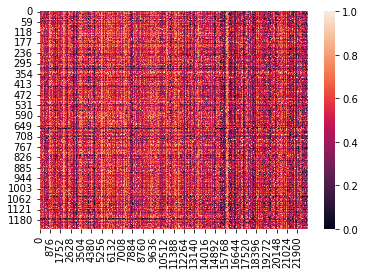

In [3]:
sns.heatmap(data)

In [ ]:
# USING ALIAS 
PAM50_genes = [
    "FOXC1", "MIA", "NDC80", #"KNTC2",
    "CEP55", "ANLN", "MELK", "GPR160", "TMEM45B", "ESR1", "FOXA1",  "ERBB2", "GRB7", "FGFR4", "BLVRA", 
    "BAG1", "CDC20", "CCNE1", "ACTR3B", "MYC", "SFRP1", "KRT14", "KRT17", "KRT5", "MLPH", "CCNB1",
    "CDC6", "TYMS", "UBE2T", "RRM2", "MMP11", "CXXC5", "ORC6", #"ORC6L",
    "MDM2", "KIF2C",  "PGR", "MKI67", "BCL2", "EGFR", "PHGDH", "CDH3", "NAT1", "SLC39A6", "MAPT",
    "UBE2C", "PTTG1", "EXO1", "CENPF", "NUF2", #"CDCA1",
    "MYBL2", "BIRC5"]
len(PAM50_genes)

In [5]:
importlib.reload(data_handler)
sample = "../../data/BRCA/0019c951-16c5-48d0-85c8-58d96b12d330/ba295155-272e-43eb-9d6a-e4c9c392e68b.rna_seq.augmented_star_gene_counts.tsv"
names = pd.DataFrame(data_handler.get_names(sample, header = 1, skiprows = [2,3,4,5]))

In [12]:
sum(names["gene_type"] == "protein_coding")/len(names) # only 32% of genes are protein coding

0.32908011869436204

In [ ]:
mask = [True if name.startswith("MT-") else False for name in names["gene_name"]]
print(sum(mask))
names[mask][0:5]

In [ ]:
mask = [True if gene in PAM50_genes else False for gene in names["gene_name"]]
names[mask]
X = data[:,mask]
median_centered_data = X - np.median(X, axis=1)[:, np.newaxis]
correlation_matrix = np.corrcoef(median_centered_data)

# Step 3: Perform Hierarchical Clustering with Average Linkage
linkage_matrix = sch.linkage(correlation_matrix, method='average')

# Step 4: Cut the Dendrogram into 5 Clusters
k = 5  # Number of clusters
cluster_labels = sch.fcluster(linkage_matrix, k, criterion='maxclust')

# Display the cluster assignments
print("Cluster Assignments:")
print(cluster_labels)

# Visualize the hierarchical clustering dendrogram
dendrogram = sch.dendrogram(linkage_matrix)  # You can adjust the color threshold here

# Display the dendrogram
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram with 5 Clusters')
plt.show()

In [ ]:
sns.clustermap(X, method='average', row_linkage = linkage_matrix, cmap='coolwarm')

In [ ]:
n_components = 2  # Number of principal components (2 for 2D plot)
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)  # Apply PCA and reduce dimensionality
X_pca = pca.fit_transform(data)  # Apply PCA and reduce dimensionality

# Step 3: Create a 2D PCA Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], marker='o', c=cluster_labels, alpha=1)
plt.title('2D PCA Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# Step 5: Create a Heatmap
# Sort the rows (genes) in the data matrix based on cluster assignments
sorted_indices = np.argsort(cluster_labels)
sorted_data = median_centered_data[sorted_indices]

# Create a heatmap using Seaborn
sns.set(font_scale=1)
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_data, cmap='coolwarm', yticklabels=False)


In [ ]:
print(len(metadata["PAM50_labels"]))
print(data.shape)

In [ ]:
n_components = 2  # Number of principal components (2 for 2D plot)
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(data)  # Apply PCA and reduce dimensionality

# Step 3: Create a 2D PCA Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], marker='o', c = metadata["PAM50_labels"])
plt.title('2D PCA Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

# Show the plot
plt.show()

In [2]:
dat = pd.read_csv('../external_aproach/BRCA.csv')
dat = dat.drop(dat.columns[[0]], axis=1)
dat = dat.T
feature_num = dat.shape[1]
data_num = dat.shape[0]
dat = dat.values.reshape(-1,1,feature_num)
print(dat.shape)

(638, 1, 11327)


In [3]:
index = pd.read_csv('../external_aproach/BRCA-label.csv', header=0)
index = index[0 :data_num].astype(int)
label = index.values.tolist()  
label = [l[0] for l in label]


# End of processing

In [4]:
dat = data
print(dat.shape)
feature_num = dat.shape[1]
dat = dat.reshape(-1,1,feature_num)
print(dat.shape)
label = metadata["PAM50_labels"]
feature_num = metadata["n_features"]

NameError: name 'data' is not defined

In [5]:
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, data1 ,transform = None):
        self.transform = transform
        self.data1 = data1
        self.datanum = len(data1)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        
        out_data1 = torch.tensor(self.data1[idx]).float() 
        if self.transform:
            out_data1 = self.transform(out_data1)

        return out_data1

In [6]:
train_data, test_data = train_test_split(dat, test_size = 0.1, random_state = 66)
print('train data:',len(train_data))
print('test data:',len(test_data))
train_data_set = Mydatasets(data1 = train_data)
test_data_set = Mydatasets(data1 = test_data)
train_dataloader = torch.utils.data.DataLoader(train_data_set, batch_size = 32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data_set, batch_size = 32, shuffle=True)

train data: 574
test data: 64


In [7]:
# for m1 mac
#DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

DEVICE = torch.device("mps")

In [10]:
importlib.reload(VQ_VAE_1)

#out_dim = 512   
out_dim = 64   

# best performer
VQ_VAE = VQ_VAE_1.Model(
            dropout = 0,
            input_size = feature_num, 
            encoder_dim = out_dim,
            num_embeddings = 512,   
            embedding_dim = 32,   
            commitment_cost = 1,
            decay= 0
           ).to(DEVICE)



# new best performer
out_dim = 64   
VQ_VAE = VQ_VAE_1.Model(
            dropout = 0.1,
            input_size = feature_num, 
            encoder_dim = out_dim,
            num_embeddings = 512,
            embedding_dim = 32,   
            commitment_cost = 1,
            decay= 0
           ).to(DEVICE)




Classifier_loss = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(VQ_VAE.parameters(), lr=1e-4, amsgrad=False)
data_variance = np.var(dat)

print(DEVICE)

mps


: 

In [9]:
EPOCH = 10000
train_res_recon_error = []
perplexities = []
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr= 0.000001)
print(optimizer.param_groups[0]['lr'])

VQ_VAE.train()


for epoch in tqdm(range(EPOCH)):
    
    running_loss = 0.0
    count = 0
    quantized_merge = torch.empty(0, 1, 64).to(DEVICE)
    
    # Training loop
    for _, inputs in enumerate(train_dataloader):
        optimizer.zero_grad()
        inputs = inputs.to(DEVICE)
        vq_loss, data_recon, perplexity, _, quantized = VQ_VAE(inputs)
        recon_error = F.mse_loss(data_recon, inputs) / data_variance
        loss = recon_error + vq_loss #+ perplexity
        loss.backward()
        optimizer.step()
        count += 1
        running_loss += loss.item()
    
    # Calculate and store training loss for this epoch
    train_loss = running_loss / count
    train_res_recon_error.append(train_loss)
    perplexities.append(perplexity.cpu().detach().numpy())


    
# Plot training and validation loss curves
epochs = np.arange(1, EPOCH + 1)
plt.plot(epochs, train_res_recon_error, label='Training Loss')
#plt.plot(epochs, val_res_recon_error, label='Validation Loss')
plt.plot(epochs, perplexities, label='Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(optimizer.param_groups[0]['lr'])


0.0001


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 2/10000 [00:05<7:23:55,  2.66s/it]


KeyboardInterrupt: 

In [10]:
#torch.save(VQ_VAE, "../workfiles/torch_temp")
torch.save(VQ_VAE, "../workfiles/torch_paper_compliant")



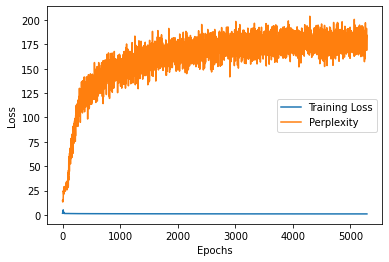

0.0001


In [11]:
# Plot training and validation loss curves
epochs = np.arange(1, EPOCH + 1)
plt.plot(train_res_recon_error, label='Training Loss')
plt.plot(perplexities, label='Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(optimizer.param_groups[0]['lr'])

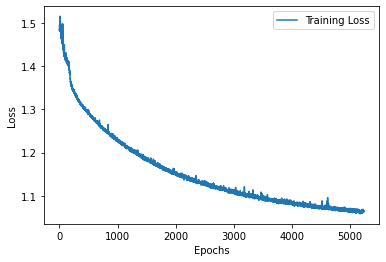

In [12]:
index = 50
plt.plot(train_res_recon_error[index:], label='Training Loss')
#plt.plot(epochs[index:], val_res_recon_error[index:], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

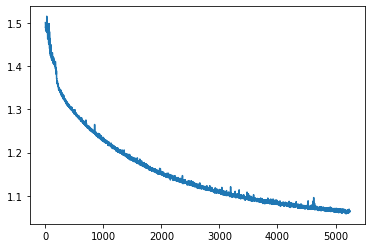

In [13]:
plt.plot(train_res_recon_error[40:], label='Training Loss')
#plt.plot(val_res_recon_error[40:], label='Training Loss')


In [14]:
en_lat = []
en_quantized = []
en_reconstruction = []

VQ_VAE.eval()

data_set = Mydatasets(data1 = dat)
data_set = torch.utils.data.DataLoader(data_set, batch_size = 256, shuffle=False) 


for i in range(len(dat)):
    en_data = data_set.dataset[i][0]
    latent_1 = VQ_VAE._encoder(en_data.view(1, 1, feature_num).float().to(DEVICE))
    _, data_recon, _, _,latent_2 = VQ_VAE(en_data.view(1, 1, feature_num).float().to(DEVICE))
    en_lat.append(latent_1.cpu().detach().numpy())
    en_quantized.append(latent_2.cpu().detach().numpy())
    en_reconstruction.append(data_recon.cpu().detach().numpy())

encode_out = np.array(en_lat)
encode_out = encode_out.reshape(len(dat), -1)
quantized_out = np.array(en_quantized)
quantized_out = quantized_out.reshape(len(dat), -1)
reconstruction_out = np.array(en_reconstruction)
reconstruction_out = reconstruction_out.reshape(len(dat), -1)

print('encode_out:', encode_out.shape)
print('quantized_out:', quantized_out.shape)

encode_out: (1231, 64)
quantized_out: (1231, 512)


In [15]:
# compatibility between notebooks
decoded_data = reconstruction_out
label = pd.Series(label)

In [16]:
print(data.shape)
print(encode_out.shape)
print(quantized_out.shape)
print(reconstruction_out.shape)

(1231, 22761)
(1231, 64)
(1231, 512)
(1231, 22761)


In [17]:
fig = sp.make_subplots(rows=2, cols=1, shared_xaxes=False, vertical_spacing=0.1)
# Add the original image as a heatmap-like plot
heatmap_trace1 = go.Heatmap(z=data[0].reshape(1, -1) )
fig.add_trace(heatmap_trace1, row=1, col=1)



# Add the decoded image as a heatmap-like plot
heatmap_trace3 = go.Heatmap(z=reconstruction_out[0].reshape(1, -1))
fig.add_trace(heatmap_trace3, row=2, col=1)
# Update layout
fig.update_layout(title='Stacked Graph of Image and Latent Space', showlegend=False)
fig.show()

/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



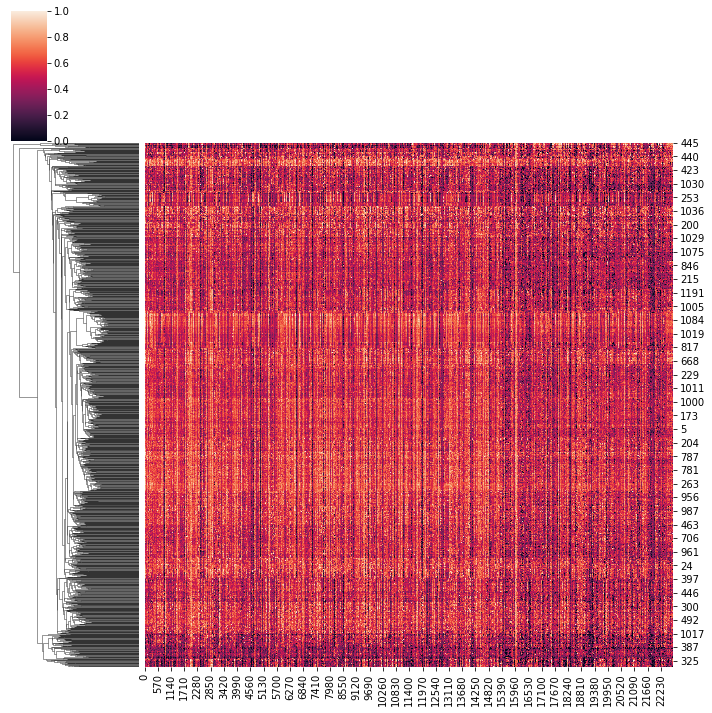

In [18]:
sns.clustermap(data, col_cluster= False)

/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



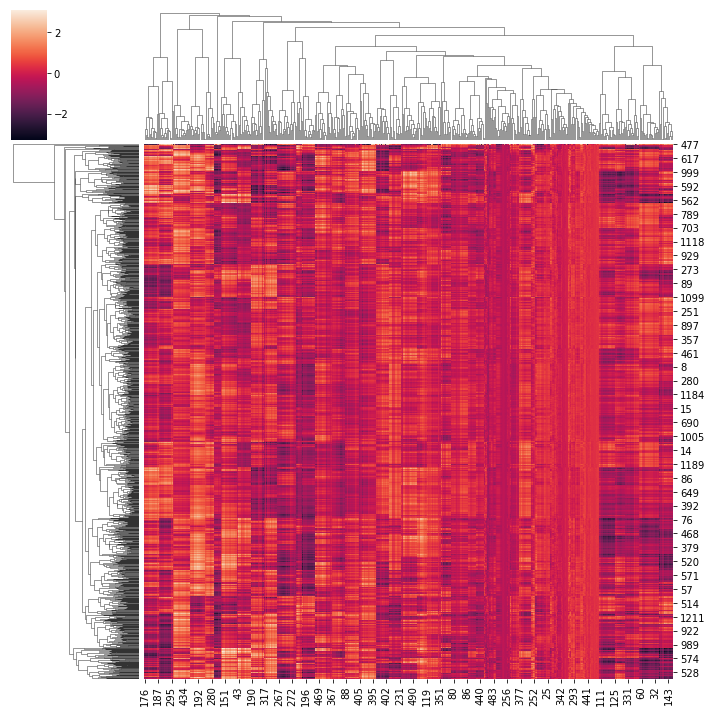

In [19]:
sns.clustermap(quantized_out)

/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



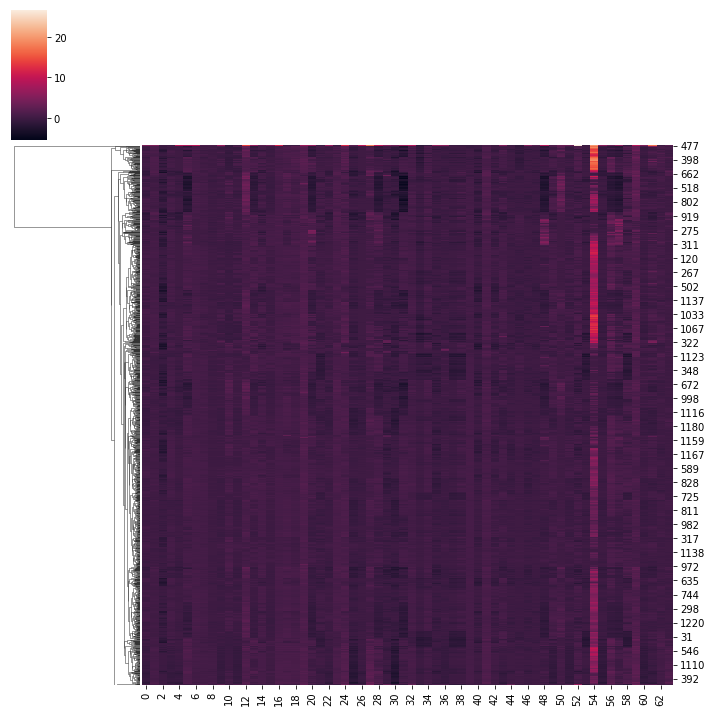

In [20]:
sns.clustermap(encode_out, col_cluster= False)

<Axes: >

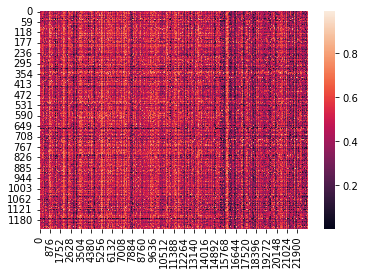

In [21]:
#sns.clustermap(decoded_data, col_cluster= False)
sns.heatmap(decoded_data)

<Axes: >

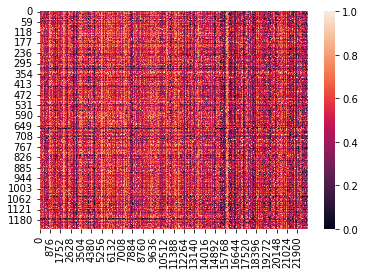

In [22]:
sns.heatmap(data)

######################## OG Groups : 


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/seaborn/utils.py:122: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



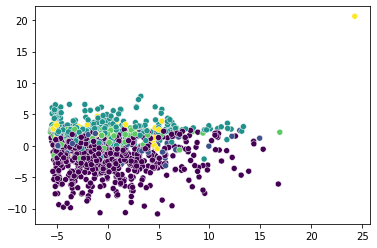

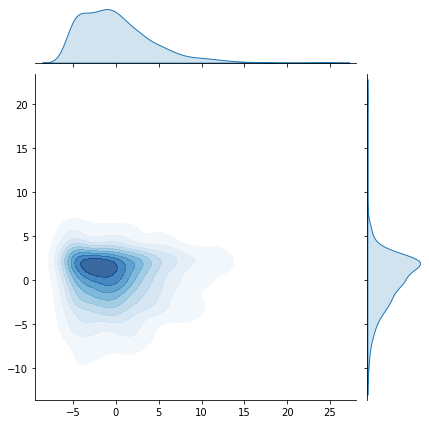

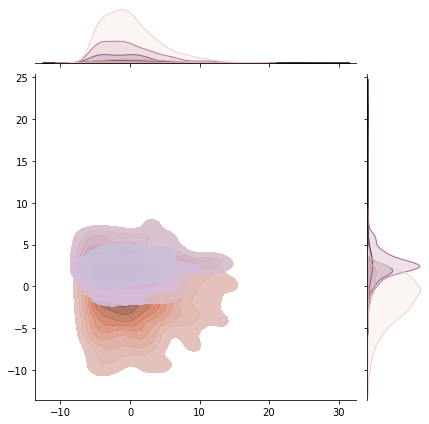

In [23]:
importlib.reload(visualisation)

print("######################## OG Groups : ")
visualisation.plot_clusters(encode_out, label)

### what happens when i use keras 

In [ ]:
from models import vanilla_autoencoder
import tensorflow as tf
from tensorflow.keras import callbacks
import datetime

In [ ]:
with open('../workfiles/BRCA_ds.pkl', 'rb') as f:
#with open('../workfiles/normed_BRCA_ds.pkl', 'rb') as f:
    
    data_original, metadata = pickle.load(f)

In [ ]:
seq_names = metadata["sequence_names"]
n_genes = metadata["n_features"]
gene_names = metadata["feature_names"] 

In [ ]:
importlib.reload(vanilla_autoencoder) # to allow modification of the script without restarting the whole session

latent_dim = 16

t_shape = (n_genes)


autoencoder = vanilla_autoencoder.generate_model(t_shape, latent_dim)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [ ]:
checkpoint_filepath = '../workfiles/simple_ae/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)


reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=20, min_lr=0.00001)

early_stopping_callback = callbacks.EarlyStopping(monitor='loss', patience=70)


log_dir = "../workfiles/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cb = [model_checkpoint_callback, reduce_lr, early_stopping_callback, tensorboard_callback]

In [ ]:
autoencoder.load_weights(checkpoint_filepath)

In [ ]:
hist = autoencoder.fit(data_original, epochs=200, callbacks=cb)  
autoencoder.load_weights(checkpoint_filepath)

In [ ]:
plt.plot(hist.history["loss"])

In [ ]:
compressed_dataframe = autoencoder.encoder.predict(data)

In [ ]:
sns.clustermap(compressed_dataframe, col_cluster= False)

In [ ]:
recon_data = autoencoder.decoder.predict(compressed_dataframe)

In [ ]:
sns.clustermap(recon_data, col_cluster= False)

# who gets the best loss?

In [ ]:
# torch dataset
squared_error = np.square(filtered_data - reconstruction_out)
mse = np.mean(squared_error)

print("Mean Squared Error:", mse)

In [ ]:
# tensorflow
squared_error = np.square(data_original - recon_data)
mse = np.mean(squared_error)

print("Mean Squared Error:", mse)

In [ ]:
visualisation.plot_clusters(compressed_dataframe, metadata['PAM50_labels'])

# clustering perf analysis

In [ ]:
from sklearn.metrics import confusion_matrix


In [ ]:
linked = linkage(encode_out, 'ward', 'euclidean')  # You can use other linkage methods as well
plt.figure(figsize=(10, 5))
dendrogram(linked, orientation='top', distance_sort='descending')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Determine the number of clusters (adjust the threshold as needed)
threshold = 50  # Adjust this threshold to identify clusters
cluster_labels = fcluster(linked, threshold, criterion='distance')

cm = confusion_matrix(cluster_labels, filtered_labs)
cm_df = pd.DataFrame(cm, 
                     index=["Actual 0", "Actual 1", "Actual 2", "Actual 3", "Actual 4"], 
                     columns=["Predicted 0", "Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4"])

print(cm_df)
sns.heatmap(cm_df)

In [ ]:
linked = linkage(compressed_dataframe, 'ward', 'euclidean')  # You can use other linkage methods as well
plt.figure(figsize=(10, 5))
dendrogram(linked, orientation='top', distance_sort='descending')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Determine the number of clusters (adjust the threshold as needed)
threshold = 290  # Adjust this threshold to identify clusters
cluster_labels = fcluster(linked, threshold, criterion='distance')


# Identify potential outliers (clusters with a small number of points)
unique_labels, counts = np.unique(cluster_labels, return_counts=True)
outlier_clusters = unique_labels[counts < threshold]
print(unique_labels)

cm = confusion_matrix(cluster_labels, metadata['PAM50_labels'])
cm_df = pd.DataFrame(cm, 
                     index=["Actual 0", "Actual 1", "Actual 2", "Actual 3", "Actual 4"], 
                     columns=["Predicted 0", "Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4"])

print(cm_df)
sns.heatmap(cm_df)